Foltányi Kolos


# Csődelőrejelzés Többáltozós Statisztikai Módszerekkel
A csődelőrejelzés alapvető célja csődvalószínűség, illetve fizetőképességet kifejező score becslése az egyes megfigyelésekhez a magyarázó változók (pénzügyi mutatók) és a csődeseményt kifejező bináris célváltozó felhasználásával.

## Csődmodellezési Adatbázis Építés

Az adatgyűjtés tárgya a modell alkalmazásához várható célportfolióra reprezentatív adatbázis összeállítása. Ez a folyamat a következő feladatokat foglalja magában:

**1. Az adatbázis elemzése alapvető leíró statisztikai jellemzők alapján** <br>
**2. Pénzügyi mutató input változók megképzése** <br>
**3. Hiányzó értékek, nullával való osztások kezelése imputációs módszerekkel** <br>
**4. Bináris célváltozó (1/0 csődesemény) megképzése** <br>
**5. Outlier értékek azonosítása és csonkolással történő kezelése**

A kiinduló adatbázist a `database.xlsx` file-ból olvassuk be egy `rawdata` nevű dataframe-be.

In [1]:
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np
import pandas as pd
import math

rawdata = pd.read_excel('database.xlsx').fillna(0)

rawdata.head()

,BeszamoloTip,AllapotLeiras,FotevTEAOR,TeaorMegnevezes,MerlegFoossz,Arbevetel,SajatToke,AdozasUtEred,UzemiUzletiTevEred,ErtekcsokkLeir,...,Keszletek,KovetelesekVevok,KovetelesekSzallitok,RovidLejKot,HosszuLejKot,ElozoMerlegFoosszeg,ElozoSajatToke,ElozoArbevetel,ElozoPenzBeszEv,PenzBeszEv
0,Egyszerűsített éves beszámoló (T 1711 AB) ERED...,Működik,4520,"Gépjárműjavítás, -karbantartás",75262,20021,35321,925,1650,375.0,...,1105,190,39941.0,9941,30000,43555,24309,21590,2013,2014
1,Egyszerűsített éves beszámoló összköltség eljá...,Működik,7112,"Mérnöki tevékenység, műszaki tanácsadás",23341,131493,2230,75443,84123,509.0,...,0,18952,21042.0,21042,0,45304,2557,130186,2013,2014
2,Egyszerűsített éves beszámoló (T 1711 AB) ERED...,Működik,4520,"Gépjárműjavítás, -karbantartás",16100,42927,4973,616,684,200.0,...,1413,10879,11127.0,9704,1423,15230,4356,38098,2013,2014
3,Éves beszámoló (T 1710 AB) EREDMÉNYKIMUTATÁS/É...,Működik,2823,Irodagép gyártása (kivéve: számítógép és perif...,473527,562055,433425,22970,23854,12383.0,...,47761,92124,37313.0,37313,0,493642,425954,578729,2013,2014
4,Egyszerűsített éves beszámoló összköltség eljá...,Működik,9601,"Textil, szőrme mosása, tisztítása",84019,110389,31587,3109,3791,20753.0,...,1005,18471,45473.0,35397,10076,54224,22478,70873,2013,2014


## 1. Az adatbázis elemzése alapvető leíró statisztikai jellemzők alapján
Az adatbázis elemzésénél a darabszám, átlag, szórás, minimum, maximum valamint a 25%, 50% és 75% percentilisek kerültek kiszámításra az összes pénzügyi mutatószámhoz.

In [2]:
summary = rawdata.describe().iloc[:,1:20]

pd.options.display.float_format = '{:.2f}'.format

summary.iloc[:,0:7]

,MerlegFoossz,Arbevetel,SajatToke,AdozasUtEred,UzemiUzletiTevEred,ErtekcsokkLeir,TargyiEszk
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,467276.11,412486.35,233583.26,-63672.63,-56471.08,16982.99,169319.25
std,3852837.37,4082148.40,3069293.66,2705483.40,2763547.25,203963.54,1166287.50
min,10026.00,10016.00,-3954139.00,-83875550.00,-85231763.00,0.00,0.00
25%,20647.75,27917.00,5188.75,198.75,345.25,288.75,902.25
50%,43807.50,59141.00,14258.00,2246.50,3029.50,1157.00,6188.50
75%,136305.00,166946.50,42680.00,9770.25,11259.00,3623.75,35919.75
max,85786071.00,124239296.00,77984400.00,15752789.00,18636439.00,6008926.00,22458472.00


In [3]:
summary.iloc[:,7:14]

,BefEszk,PenzEszk,Ertekpapirok,ForgoEszk,Keszletek,KovetelesekVevok,KovetelesekSzallitok
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,187828.49,22897.22,2599.66,261255.10,46359.61,189400.07,211775.94
std,1194236.26,85084.29,32098.75,3158575.80,435026.79,2997634.61,1194094.57
min,0.00,0.00,0.00,29.00,0.00,0.00,0.00
25%,1163.50,1287.00,0.00,12686.50,0.00,3001.00,9644.25
50%,7786.00,4961.50,0.00,26047.50,447.00,11120.50,22635.00
75%,43812.50,13096.25,0.00,65847.50,8859.25,31697.50,78555.25
max,23313842.00,1115466.00,822580.00,84197553.00,9219831.00,84194336.00,22801319.00


In [4]:
summary.iloc[:,14:]

,RovidLejKot,HosszuLejKot,ElozoMerlegFoosszeg,ElozoSajatToke,ElozoArbevetel
count,1000.00,1000.00,1000.00,1000.00,1000.00
mean,125440.02,70075.88,462583.20,261959.49,394492.35
std,635485.94,682586.36,4812501.83,4456089.54,3497749.68
min,0.00,0.00,0.00,-275789.00,0.00
25%,7295.25,0.00,15303.75,3443.00,20797.00
50%,17676.00,0.00,36411.00,11095.00,48124.50
75%,57933.50,4415.00,113466.50,40399.00,136602.25
max,12924803.00,18834823.00,137975662.00,134713597.00,104131231.00


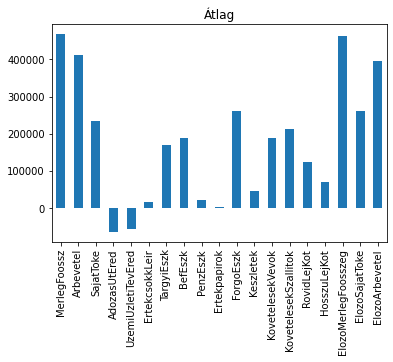

In [5]:
summary.loc['mean',:].plot.bar(title='Átlag');

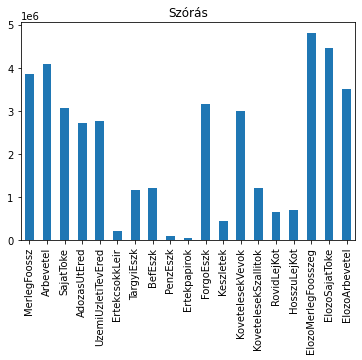

In [6]:
summary.loc['std',:].plot.bar(title='Szórás');

## 2. Pénzügyi mutató input változók megképzése
Az alábbi függvények egy új data frame létrehozását szolgálják, mely a kiszámolt pénzügyi mutatószámokat foglalja magában. A szabálytalanul számolt (0-val való osztás, kettős negatív osztás, ...) értékek helyére az őket helyettesítő imputációs módszert jelölő konstansok kerülnek. A számítások után a konstansokból segédfüggvényekkel számolható a megfelelő imputációs módszerrel a helyettesítő érték. A gyakori helyettesítő szabályok alkalmazását a lent definiált függvények segítik.

In [7]:
MIN_IMPUT = "MIN_IMPUT"
MAX_IMPUT = "MAX_IMPUT"
MEDIAN_IMPUT = "MEDIAN_IMPUT"

def fullImputated(numerator, denominator):
    if denominator == 0 and numerator > 0:
        return MAX_IMPUT
    elif denominator == 0 and numerator == 0:
        return MEDIAN_IMPUT
    elif denominator == 0 and numerator < 0:
        return MIN_IMPUT
    else:
        return numerator / denominator
    
def zeroDivisionImputated(numerator, denominator):
    if denominator == 0:
        return MAX_IMPUT
    else:
        return numerator / denominator

**Sajáttőke-arányos nyereség (ROE) számítása:** <br>
Adózott eredmény / Átlagos saját tőke

In [8]:
def calcROE(data):
    result = []
    for index, row in data.iterrows():
        auEredm = row['AdozasUtEred']
        meanST = (row['SajatToke'] + row['ElozoSajatToke'])/2
        if auEredm < 0 and meanST < 0:
            result.append(MIN_IMPUT)
        elif meanST == 0:
            result.append(MIN_IMPUT)
        else:
            result.append(auEredm / meanST)
    return result

**Eszközarányos nyereség (ROA):** <br>
Adózott eredmény / Átlagos mérlegfőösszeg

In [9]:
def calcROA(data):
    meanMFO = (data['MerlegFoossz'] + data['ElozoMerlegFoosszeg'])/2
    return data['AdozasUtEred'] / meanMFO

**EBITDA jövedelmezőség:** <br>
(Üzemi tevékenység eredménye + Értékcsökkenési leírás) / Átlagos mérlegfőösszeg

In [10]:
def calcEBITDA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['UzemiUzletiTevEred'] + row['ErtekcsokkLeir']
        denom = (row['MerlegFoossz'] + row['ElozoMerlegFoosszeg'])/2
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Árbevételarányos nyereség (ROS):** <br>
Üzemi (üzleti) tevékenység eredménye / Értékesítés nettó árbevétele

In [11]:
def calcROS(data):
    numerator = data['UzemiUzletiTevEred'] + data['ErtekcsokkLeir']
    return numerator / data['Arbevetel']

**Árbevételarányos EBITDA:** <br>
(Üzemi (üzleti) tevékenység eredménye + Értékcsökkenési leírás) / Értékesítés nettó árbevétele 

In [12]:
def calcARBEV_ARANYOS_EBITDA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['UzemiUzletiTevEred'] + row['ErtekcsokkLeir']
        denom = row['Arbevetel']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Eszközarányos árbevétel (fordulatszám):** <br>
Értékesítés nettó árbevétele / Átlagos mérlegfőösszeg

In [13]:
def calcESZK_ARANYOS_ARBEV(data):
    result = []
    for index, row in data.iterrows():
        numer = row['Arbevetel']
        denom = (row['MerlegFoossz'] + row['ElozoMerlegFoosszeg'])/2
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Készletek forgási sebessége (fordulatszám):** <br>
Értékesítés nettó árbevétele / Átlagos készletállomány

In [14]:
def calcKESZLET_FORG_SEB(data):
    result = []
    for index, row in data.iterrows():
        numer = row['Arbevetel']
        denom = row['Keszletek']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Vevők forgási sebessége (fordulatszám):** <br>
Értékesítés nettó árbevétele / Átlagos vevőállomány

In [15]:
def calcESZK_FORG_SEB(data):
    result = []
    for index, row in data.iterrows():
        numer = row['Arbevetel']
        denom = row['KovetelesekVevok']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Likviditási ráta:** <br>
Forgóeszközök / Rövid lejáratú kötelezettségek

In [16]:
def calcLIKVID_RATA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['ForgoEszk']
        denom = row['RovidLejKot']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Likviditási gyorsráta:** <br>
(Forgóeszközök - Készletek) / Rövid lejáratú kötelezettségek

In [17]:
def calcLIKVID_GYORSRATA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['ForgoEszk'] - row['Keszletek']
        denom = row['RovidLejKot']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Készpénz likviditás:** <br>
(Pénzeszközök + Értékpapírok) / Rövid lejáratú kötelezettségek

In [18]:
def calcKESZPENZ_LIKVID(data):
    result = []
    for index, row in data.iterrows():
        numer = row['PenzEszk'] + row['Ertekpapirok']
        denom = row['RovidLejKot']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Dinamikus likviditás:** <br>
Üzemi (üzleti) tevékenység eredménye / Rövid lejáratú kötelezettségek

In [19]:
def calcDINAMIKUS_LIKVID(data):
    result = []
    for index, row in data.iterrows():
        numer = row['UzemiUzletiTevEred']
        denom = row['RovidLejKot']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Saját vagyon aránya:** <br>
Saját tőke / Mérlegfőösszeg

In [20]:
def calcSAJAT_VAGYON_ARANYA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['SajatToke']
        denom = row['MerlegFoossz']
        if denom == 0:
            result.append(MIN_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Eladósodottság mértéke:** <br>
Kötelezettségek / Mérlegfőösszeg

In [21]:
def calcELADOS_MERTEKE(data):
    result = []
    for index, row in data.iterrows():
        numer = row['RovidLejKot'] + row['HosszuLejKot']
        denom = row['MerlegFoossz']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Hosszú távú eladósodottság:**<br>
Hosszú lejáratú kötelezettségek / (Saját tőke + Hosszú lejáratú kötelezettségek)

In [22]:
def calcHOSSZU_TAVU_ELADOS(data):
    result = []
    for index, row in data.iterrows():
        numer = row['HosszuLejKot']
        denom = row['SajatToke'] + row['HosszuLejKot']
        if denom <= 0:
            result.append(MAX_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Idegen tőke / Saját tőke arány:** <br>
Kötelezettségek / Saját tőke

In [23]:
def calcIDEGEN_SAJAT_TOKE_ARANY(data):
    result = []
    for index, row in data.iterrows():
        numer = row['RovidLejKot'] + row['HosszuLejKot']
        denom = row['SajatToke']
        if denom <= 0:
            result.append(MAX_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Befektetett eszközök saját finanszírozása:** <br>
Saját tőke / Befektetett eszközök

In [24]:
def calcBEFESZK_SAJAT_FIN(data):
    result = []
    for index, row in data.iterrows():
        numer = row['SajatToke']
        denom = row['BefEszk']
        if denom == 0 and numer <= 0:
            result.append(MIN_IMPUT)
        elif denom == 0 and numer > 0:
            result.append(MEDIAN_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Befektetett eszközök idegen finanszírozása:** <br>
Hosszú lejáratú kötelezettségek / Befektetett eszközök

In [25]:
def calcBEFESZK_IDEGEN_FIN(data):
    result = []
    for index, row in data.iterrows():
        numer = row['HosszuLejKot']
        denom = row['BefEszk']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Dinamikus jövedelmezőségi ráta (bruttó):** <br>
(Adózott eredmény + Értékcsökkenési leírás) / Átlagos mérlegfőösszeg

In [26]:
def calcDIN_JOVED_RATA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['AdozasUtEred'] + row['ErtekcsokkLeir']
        denom = (row['MerlegFoossz']+ row['ElozoMerlegFoosszeg'])/2
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Cash flow / összes tartozás:**<br>
(Adózott eredmény + Értékcsökkenési leírás) / (Hosszú lejáratú kötelezettségek + Rövid lejáratú kötelezettségek)

In [27]:
def calcCASH_FLOW_TART_RATA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['AdozasUtEred'] + row['ErtekcsokkLeir']
        denom = row['HosszuLejKot'] + row['RovidLejKot']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Cash-flow / nettó árbevétel:**<br>
(Adózott eredmény + Értékcsökkenési leírás) / Értékesítés nettó árbevétele

In [28]:
def calcCASH_FLOW_ARBEV_RATA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['AdozasUtEred'] + row['ErtekcsokkLeir']
        denom = row['Arbevetel']
        ans = fullImputated(numer, denom)
        result.append(ans)
    return result

**Mérlegfőösszeg nagysága:** <br>
log (Mérlegfőösszeg)

In [29]:
def calcMFO_NAGYSAG(data):
    return [math.log(x) for x in data['MerlegFoossz']]

**Éves árbevétel nagysága:** <br>
log (Értékesítés nettó árbevétele)

In [30]:
def calcARBEV_NAGYSAG(data):
    return [math.log(x) for x in data['Arbevetel']]

**Árbevétel növekedési üteme:** <br>
Értékesítés nettó árbevétele tárgyidőszak / Értékesítés nettó árbevétele előző időszak

In [31]:
def calcARBEV_NOVEK(data):
    result = []
    for index, row in data.iterrows():
        numer = row['Arbevetel']
        denom = row['ElozoArbevetel']
        if denom == 0 and numer >= 0:
            result.append(MEDIAN_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Tőkeellátottsági mutató:** <br>
(Befektetett eszközök + Készletek) / Saját tőke

In [32]:
def calcTOKE_ELLAT(data):
    result = []
    for index, row in data.iterrows():
        numer = row['BefEszk'] + row['Keszletek']
        denom = row['SajatToke']
        if denom == 0:
            result.append(MIN_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Forgóeszközök aránya:**<br>
Forgóeszközök / Mérlegfőösszeg

In [33]:
def calcFORGO_ESZK_ARANYA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['ForgoEszk']
        denom = row['MerlegFoossz']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Likvid pénzeszközök aránya:** <br>
(Pénzeszközök + Értékpapírok) / Forgóeszközök

In [34]:
def calcLIKVID_PENZESZK_ARANYA(data):
    result = []
    for index, row in data.iterrows():
        numer = row['PenzEszk'] + row['Ertekpapirok']
        denom = row['ForgoEszk']
        if denom == 0 and numer == 0:
            result.append(MEDIAN_IMPUT)
        else:
            result.append(numer/denom)
    return result

**Nettó forgótőke arány:** <br>
(Forgóeszközök - Rövid lejáratú kötelezettségek) / Mérlegfőösszeg

In [35]:
def calcFORGO_TOKE_ARANY(data):
    result = []
    for index, row in data.iterrows():
        numer = row['ForgoEszk'] - row['RovidLejKot']
        denom = row['MerlegFoossz']
        ans = zeroDivisionImputated(numer, denom)
        result.append(ans)
    return result

**Vevők / Szállítók aránya:** <br>
Vevőkövetelések / Szállítói kötelezettségek

In [36]:
def calcVEVO_SZALLITO_ARANY(data):
    result = []
    for index, row in data.iterrows():
        numer = row['KovetelesekVevok']
        denom = row['KovetelesekSzallitok']
        if denom == 0:
            result.append(MEDIAN_IMPUT)
        else:
            result.append(numer/denom)
    return result

## 3. Hiányzó értékek, nullával való osztások kezelése imputációs módszerekkel
A pénzügyi mutatók kiszámításának implementációja után el lehet végezni a konkrét imputációs módszerek végrehajtását. Az alábbi `applyImputations` függvény minden adatsorban a fent beírt imputációs módszert indikáló string konstansokat a megfelelő helyettesítő értékre cseréli. Az `imputationStats` segédfüggvény pedig megszámolja a különböző imputációs eljárások alkalmazását. 

In [37]:
methods = {
    MIN_IMPUT: min,
    MAX_IMPUT: max,
    MEDIAN_IMPUT: stats.median
}

def applyImputations(arr):
    nums = [x for x in arr if type(x) is not str]
    for x in arr:
        if type(x) is str:
            yield methods[x](nums)
        else:
            yield x
            
def imputationStats(record):
    minc = len([x for x in record if x == MIN_IMPUT])
    maxc = len([x for x in record if x == MAX_IMPUT])
    medc = len([x for x in record if x == MEDIAN_IMPUT])
    description = []
    if minc > 0:
        description.append(f"Minimum Imputálva: {minc} ")
    if maxc > 0:
        description.append(f"Maximum Imputálva: {maxc} ")
    if medc > 0:
        description.append(f"Medián Imputálva: {medc} ")
    if minc == 0 and maxc == 0 and medc == 0:
        description.append("Nem kellet imputálni")    
    return description

Nincs más hátra mint előre! A fenti függvény segítségével elkészíthető a végelges data frame, mely az imputációs eljárásokkal generált pénzügyi mutatószámokat tárolja.

In [56]:
database = pd.DataFrame()

factory = {
    'ROE': calcROE,
    'ROA': calcROA,
    'EBITDA': calcEBITDA,
    'ROS': calcROS,
    'ARBEV_ARANYOS_EBITDA': calcARBEV_ARANYOS_EBITDA,
    'ESZK_ARANYOS_ARBEV': calcESZK_ARANYOS_ARBEV,
    'KESZLET_FORG_SEB': calcKESZLET_FORG_SEB,
    'ESZK_FORG_SEB': calcESZK_FORG_SEB,
    'LIKVID_RATA': calcLIKVID_RATA,
    'LIKVID_GYORSRATA': calcLIKVID_GYORSRATA,
    'KESZPENZ_LIKVID': calcKESZPENZ_LIKVID,
    'DINAMIKUS_LIKVID': calcDINAMIKUS_LIKVID,
    'SAJAT_VAGYON_ARANYA': calcSAJAT_VAGYON_ARANYA,
    'ELADOS_MERTEKE': calcELADOS_MERTEKE,
    'HOSSZU_TAVU_ELADOS': calcHOSSZU_TAVU_ELADOS,
    'IDEGEN_SAJAT_TOKE_ARANY': calcIDEGEN_SAJAT_TOKE_ARANY,
    'BEFESZK_SAJAT_FIN': calcBEFESZK_SAJAT_FIN,
    'BEFESZK_IDEGEN_FIN': calcBEFESZK_IDEGEN_FIN,
    'DIN_JOVED_RATA': calcDIN_JOVED_RATA,
    'CASH_FLOW_TART_RATA': calcCASH_FLOW_TART_RATA,
    'CASH_FLOW_ARBEV_RATA': calcCASH_FLOW_ARBEV_RATA,
    'MFO_NAGYSAG': calcMFO_NAGYSAG,
    'ARBEV_NAGYSAG': calcARBEV_NAGYSAG,
    'ARBEV_NOVEK': calcARBEV_NOVEK,
    'TOKE_ELLAT': calcTOKE_ELLAT,
    'FORGO_ESZK_ARANYA': calcFORGO_ESZK_ARANYA,
    'LIKVID_PENZESZK_ARANYA': calcLIKVID_PENZESZK_ARANYA,
    'FORGO_TOKE_ARANY': calcFORGO_TOKE_ARANY,
    'VEVO_SZALLITO_ARANY': calcVEVO_SZALLITO_ARANY
}

for key in factory:
    record = factory[key](rawdata)
    database[key] = [x for x in applyImputations(record)]
    print(key, imputationStats(record))

ROE ['Minimum Imputálva: 73 ']
ROA ['Nem kellet imputálni']
EBITDA ['Nem kellet imputálni']
ROS ['Nem kellet imputálni']
ARBEV_ARANYOS_EBITDA ['Nem kellet imputálni']
ESZK_ARANYOS_ARBEV ['Nem kellet imputálni']
KESZLET_FORG_SEB ['Maximum Imputálva: 444 ']
ESZK_FORG_SEB ['Maximum Imputálva: 19 ']
LIKVID_RATA ['Maximum Imputálva: 2 ']
LIKVID_GYORSRATA ['Maximum Imputálva: 2 ']
KESZPENZ_LIKVID ['Maximum Imputálva: 2 ']
DINAMIKUS_LIKVID ['Maximum Imputálva: 2 ']
SAJAT_VAGYON_ARANYA ['Nem kellet imputálni']
ELADOS_MERTEKE ['Nem kellet imputálni']
HOSSZU_TAVU_ELADOS ['Maximum Imputálva: 91 ']
IDEGEN_SAJAT_TOKE_ARANY ['Maximum Imputálva: 117 ']
BEFESZK_SAJAT_FIN ['Minimum Imputálva: 15 ', 'Medián Imputálva: 65 ']
BEFESZK_IDEGEN_FIN ['Maximum Imputálva: 80 ']
DIN_JOVED_RATA ['Nem kellet imputálni']
CASH_FLOW_TART_RATA ['Minimum Imputálva: 1 ']
CASH_FLOW_ARBEV_RATA ['Nem kellet imputálni']
MFO_NAGYSAG ['Nem kellet imputálni']
ARBEV_NAGYSAG ['Nem kellet imputálni']
ARBEV_NOVEK ['Medián Imputálva

Az így kapott adatbázis tartalmazza a legfontosabb pénzügyi indikátorokat, melyek a modellünk input változóit képzik a továbbiakban. Az adatbázis első 5 rekordjának értékei lentebb láthatóak.

In [39]:
pd.options.display.float_format = '{:.2f}'.format

database.iloc[:,0:7].head()

,ROE,ROA,EBITDA,ROS,ARBEV_ARANYOS_EBITDA,ESZK_ARANYOS_ARBEV,KESZLET_FORG_SEB
0,0.03,0.02,0.03,0.10,0.10,0.34,18.12
1,31.52,2.20,2.47,0.64,0.64,3.83,36045.43
2,0.13,0.04,0.06,0.02,0.02,2.74,30.38
3,0.05,0.05,0.07,0.06,0.06,1.16,11.77
4,0.12,0.04,0.36,0.22,0.22,1.60,109.84


In [40]:
database.iloc[:,6:11].head()

,KESZLET_FORG_SEB,ESZK_FORG_SEB,LIKVID_RATA,LIKVID_GYORSRATA,KESZPENZ_LIKVID
0,18.12,105.37,0.23,0.12,0.10
1,36045.43,6.94,1.10,1.10,0.20
2,30.38,3.95,1.33,1.18,0.06
3,11.77,6.10,9.13,7.85,5.38
4,109.84,5.98,0.57,0.54,0.02


In [41]:
database.iloc[:,11:15].head()

,DINAMIKUS_LIKVID,SAJAT_VAGYON_ARANYA,ELADOS_MERTEKE,HOSSZU_TAVU_ELADOS
0,0.17,0.47,0.53,0.46
1,4.00,0.10,0.90,0.00
2,0.07,0.31,0.69,0.22
3,0.64,0.92,0.08,0.00
4,0.11,0.38,0.54,0.24


In [42]:
database.iloc[:,15:19].head()

,IDEGEN_SAJAT_TOKE_ARANY,BEFESZK_SAJAT_FIN,BEFESZK_IDEGEN_FIN,DIN_JOVED_RATA
0,1.13,0.48,0.41,0.02
1,9.44,43.73,0.00,2.21
2,2.24,1.54,0.44,0.05
3,0.09,3.48,0.00,0.07
4,1.44,0.65,0.21,0.35


In [43]:
database.iloc[:,19:24].head()

,CASH_FLOW_TART_RATA,CASH_FLOW_ARBEV_RATA,MFO_NAGYSAG,ARBEV_NAGYSAG,ARBEV_NOVEK
0,0.03,0.06,11.23,9.90,0.93
1,3.61,0.58,10.06,11.79,1.01
2,0.07,0.02,9.69,10.67,1.13
3,0.95,0.06,13.07,13.24,0.97
4,0.52,0.22,11.34,11.61,1.56


In [44]:
database.iloc[:,24:].head()

,TOKE_ELLAT,FORGO_ESZK_ARANYA,LIKVID_PENZESZK_ARANYA,FORGO_TOKE_ARANY,VEVO_SZALLITO_ARANY
0,2.10,0.03,0.43,-0.10,0.00
1,0.02,0.99,0.18,0.09,0.90
2,0.93,0.80,0.04,0.20,0.98
3,0.40,0.72,0.59,0.64,2.47
4,1.57,0.24,0.03,-0.18,0.41


## 4. Bináris célváltozó (1/0 csődesemény) megképzése
A célváltozó képzés a csődbe jutás (default-tá, fizetésképtelenné válás) definícióján alapul, és bináris változót jelent. A cég csődös, ha valamely csődesemény bekövetkezett, ilyen lehet a csődeljárás, felszámolási eljárás, kényszertörlés megindítása, illetve legalább 90 napos hátralékos teljesítés bekövetkezése. A célváltozót ezen eseményekre vonatkozó információkból képezzük, melyek a beolvasott adatbázis `AllapotLeiras` oszlopában találhatóak.

Lássuk először a lehetséges értékeket:

In [45]:
set(rawdata['AllapotLeiras'])

{'A cég csőd eljárás alatt áll',
 'A cég felszámolási eljárás alatt áll',
 'A cég kényszertörlési eljárás alatt áll',
 'Működik'}

A különböző értékeket megszámolva, egy oszlopdiagramon meg tudjuk jeleníteni az egyes események előfordulásainak sokaságát:

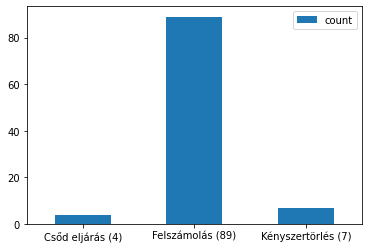

In [57]:
prettylabs = {
    'A cég csőd eljárás alatt áll': 'Csőd eljárás',
    'A cég felszámolási eljárás alatt áll': 'Felszámolás',
    'A cég kényszertörlési eljárás alatt áll': 'Kényszertörlés',
}

possibleEvents = prettylabs.keys()
events = list(rawdata['AllapotLeiras'])
counts = [events.count(x) for x in possibleEvents]
countmap = dict(zip(possibleEvents, counts))

indexes = [prettylabs[x] + f" ({countmap[x]})" for x in possibleEvents]

df = pd.DataFrame({'count': counts,}, index = indexes)

df.plot.bar(rot=0);

Látható, hogy a legtöbb csődesemény oka a felszámolási eljárás. Az eseményeket bináris változóvá transzfromálva ki tudjuk egészíteni az adatbázisunkat a fizetőképességet indikáló célváltozóval:

In [59]:
binmap = {
    'A cég csőd eljárás alatt áll': 0,
    'A cég felszámolási eljárás alatt áll': 0,
    'A cég kényszertörlési eljárás alatt áll': 0,
    'Működik': 1
}

binlist = [binmap[x] for x in events]

database['FIZETOKEPES'] = binlist

database.loc[96:101,["ROA","FIZETOKEPES"]]

,ROA,FIZETOKEPES
96,-0.36,1
97,0.03,1
98,-0.06,1
99,-0.04,0
100,0.06,1
101,0.01,1


## 5. Outlier értékek azonosítása és csonkolással történő kezelése
Az outlier értékek olyan megfigyelt értékek, amelyek kilógnak a többi érték közül, nem tűnnek hihetőnek, túl nagyok, illetve túl kicsik. Az alapsokaság vagy a véletlen mintavétel általában nem hiba, hanem valós folyamatok révén tartalmaz outlier értékeket. Az outlier értékeket az alábbi kódrészlet a **percentilisek csonkolásával** szűri ki. A felső és alsó 5% precentilis-be eső értékeket a percentilis értékére változtatja.



In [48]:
lower = dict(database.quantile(q=.05))
upper = dict(database.quantile(q=.95))

def truncate(vals, percentile, isUpper):
    for i in range(len(vals)):
        if isUpper and vals[i] > percentile:
            vals[i] = percentile
        elif not isUpper and vals[i] < percentile:
            vals[i] = percentile

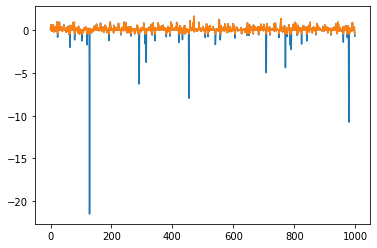

In [49]:
vals = list(database["ROS"])
percentile = lower["ROS"]
plt.plot(vals)
truncate(vals, percentile, False)
plt.plot(vals);

Az árbevételarányos nyereség pédáján jól látszik a csonkolás eredménye. A narancssárga szín jelzi az alsó 5% percentilis csonkolásából keletkezett adatokat. A kiugró értékek eltávolításával egy jóval reprezentatívabb adatsort nyerünk, mely alkalmasabb lesz a későbbiekben modellek készítésére.

In [52]:
def truncateDatabase():
    for col in database:
        if col is 'FIZETOKEPES':
            continue
        else:
            vals = list(database[col])
            lowerp = lower[col]
            truncate(vals, lowerp, False)
            upperp = upper[col]
            truncate(vals, upperp, True)
            database[col] = vals
    
truncateDatabase()

Az outlier értékek kezelésével létrejött a végleges adatbázis, melyet a továbbiakban fel tudunk használni csődvalószínűség, illetve fizetőképességet kifejező score becslésére. A végleges táblát a `result.xslx` nevű állományba mentjük.

In [54]:
database.to_excel("result.xlsx")